In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
# Set themes
file_extensions <- c(".png", ".pdf")

plot_theme <- theme(
    title = element_text(size = 9),
    axis.title = element_text(size = 9),
    legend.text = element_text(size = 7),
    legend.title = element_text(size = 9),
    legend.key.size = unit(0.5, "cm"),
    strip.text = element_text(size = 10),
    strip.background = element_rect(colour="black", fill="#fdfff4")
)

In [3]:
# Load L2 distances per MOA
cp_file <- file.path("data", "MOA_LSA_zscores.tsv")
cp_df <- readr::read_tsv(cp_file)

cp_df$model <- factor(
    cp_df$model,
    levels = c("Vanilla", "Beta", "MMD", "PCA", "Complete")
)

head(cp_df)

Rows: 420 Columns: 3

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): MOA, model
dbl (1): zscore


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



MOA,model,zscore
<chr>,<fct>,<dbl>
NFkB pathway inhibitor|proteasome inhibitor,Vanilla,-3.153561
NFkB pathway inhibitor|proteasome inhibitor,Beta,-3.143671
NFkB pathway inhibitor|proteasome inhibitor,MMD,-3.153877
NFkB pathway inhibitor|proteasome inhibitor,PCA,-2.970405
NFkB pathway inhibitor|proteasome inhibitor,Complete,-2.806738
dopamine receptor antagonist|serotonin receptor antagonist,Vanilla,-1.179638


In [4]:
# Compare performance means across architectures
cp_mean_df <- cp_df %>%
    dplyr::group_by(model) %>%
    dplyr::mutate(
        model_mean = round(mean(zscore), 2)
    ) %>%
    dplyr::select(model, model_mean) %>%
    dplyr::distinct()

cp_mean_df

model,model_mean
<fct>,<dbl>
Vanilla,-0.34
Beta,-0.23
MMD,-0.42
PCA,-0.19
Complete,-0.09


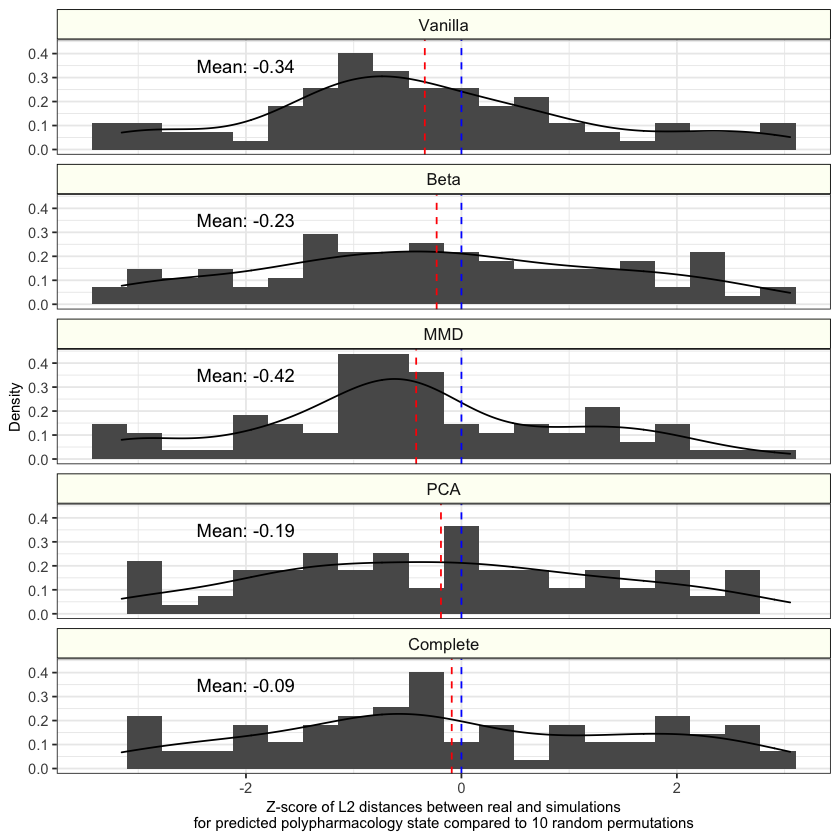

In [5]:
plot_gg <- (
    ggplot(cp_df, aes(x=zscore))
    + geom_histogram(aes(y = ..density..), bins=20)
    + geom_density()
    + geom_text(data=cp_mean_df, aes(x = -2, y = 0.35, label = paste0("Mean: ", model_mean)))
    + geom_vline(data=cp_mean_df, aes(xintercept = model_mean), color = "red", linetype="dashed")
    + facet_wrap("model", nrow = 5)
    + geom_vline(xintercept = 0, linetype = "dashed", color = "blue")
    + theme_bw()
    + plot_theme
    + ylab("Density")
    + xlab("Z-score of L2 distances between real and simulations\nfor predicted polypharmacology state compared to 10 random permutations")
    
)
plot_gg

In [6]:
# Save figure
output_file_base <- file.path("output", "sup_fig_lsa_zscores")
for (file_extension in file_extensions) {
    output_file <- paste0(output_file_base, file_extension)
    ggplot2::ggsave(output_file, plot_gg, dpi = 500, width = 6, height = 8)
}